In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
#可以直接从浏览器http://mattmahoney.net/dc/text8.zip下载text8.zip
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
filename="text8.zip"
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Word size %d' % len(words))
#print 17005207

Word size 17005207


In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)#按顺序编号
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#data：大小和words一样，是word在dictionary中的索引eg:123
#count:按照出现次数由大到小排序，eg：('the', 1061396)
#dictionary：eg. 'bled': 38573,
#reverse_dictionary: eg. 1: 'the'
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3082, 12, 6, 195, 2, 3135, 46, 59, 156]


In [199]:
data_index = 7

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size,num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #print(buffer)
  for i in range(batch_size):
    bj = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]    
    for j in range(num_skips):
      while bj in targets_to_avoid:
        bj = random.randint(0, num_skips)
      targets_to_avoid.append(bj)
      batch[i,j] = buffer[bj]
    labels[i, 0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
print(data[:8])
#test
for num_skips, skip_window in [(2, 1), (4,2), (8, 4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print(batch)
    print(labels)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
[5234, 3082, 12, 6, 195, 2, 3135, 46]
[[  12 5234]
 [3082    6]
 [ 195   12]
 [   2    6]
 [ 195 3135]
 [   2   46]
 [  59 3135]
 [  46  156]]
[[3082]
 [  12]
 [   6]
 [ 195]
 [   2]
 [3135]
 [  46]
 [  59]]

with num_skips = 2 and skip_window = 1:
[[3082  195    6 5234]
 [   2   12 3082  195]
 [3135   12    2    6]
 [   6 3135  195   46]
 [ 195    2   46   59]
 [3135   59  156    2]
 [  46  156  128 3135]
 [ 742   46   59  128]]
[[  12]
 [   6]
 [ 195]
 [   2]
 [3135]
 [  46]
 [  59]
 [ 156]]

with num_skips = 4 and skip_window = 2:
[[ 5234  3135    59    46  3082    12     6     2]
 [   46    59   195    12   156     6  3135  3082]
 [   12    46    59   156   195   128     6     2]
 [   59     6  3135   195   128   742   156     2]
 [  477   742     2   128   195   156  3135    46]
 [   59   742     2 10619    46  3135   477   128]
 [10619   134   477    46    59   156   742  3135]
 [10619   128    59   134 

In [214]:
batch_size = 128
embedding_size = 150 # Dimension of the embedding vector.
skip_window = 2 
num_skips = 4 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 50 # Only pick dev samples in the head of the distribution.
valid_examples = np.random.randint(0,valid_window,[valid_size,num_skips])

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, shape=[valid_size,num_skips], dtype=tf.int32)
  
  # Variables.
  #有vocabulary_size个容量为embedding_size的向量，每个向量代表一个vocabulary，
  #每个向量的中的分量的值都在-1到1之间随机分布
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  #调用tf.nn.embedding_lookup，索引与train_dataset对应的向量，相当于用train_dataset作为一个id，
  #去检索矩阵中与这个id对应的embedding
  #print(embeddings)
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed_sum = tf.reduce_sum(embed, 1)/num_skips #x轴上的元素相加
  #print(embed,embed_sum)
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
    
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  valid_embeddings_sum = tf.reduce_sum(valid_embeddings, 1)/num_skips
  similarity = tf.matmul(valid_embeddings_sum, tf.transpose(normalized_embeddings))


In [212]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 4, 150) dtype=float32>

In [222]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      #print(len(sim[0]))
      for i in range(valid_size):
        valid_word = []
        for j in range(num_skips):
            valid_word.append(reverse_dictionary[valid_examples[i][j]])
        nearest = (-sim[i,:]).argsort()[0]
        #print(valid_examples[i][j],(-sim[i,:]).argsort())
        #print("nearest:",nearest)
        log = 'Nearest to %s:' % valid_word
        close_word = reverse_dictionary[nearest]
        log = '%s %s,' % (log, close_word)
        print(log)
        #print(valid_examples[i],"--center:",nearest[0])
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.310175
Nearest to ['of', 'from', 'has', 'zero']: from,
Nearest to ['with', 'and', 'two', 'this']: and,
Nearest to ['four', 'he', 'as', 'was']: four,
Nearest to ['for', 'seven', 'also', 'as']: seven,
Nearest to ['his', 'for', 'that', 'with']: for,
Nearest to ['a', 'their', 'nine', 'also']: their,
Nearest to ['also', 'was', 'has', 'seven']: also,
Nearest to ['seven', 'had', 'other', 'a']: other,
Nearest to ['but', 'a', 'in', 'to']: to,
Nearest to ['one', 'had', 'four', 'UNK']: had,
Nearest to ['six', 'this', 'some', 'has']: some,
Nearest to ['first', 'also', 'as', 'was']: was,
Nearest to ['have', 'his', 'this', 'in']: in,
Nearest to ['are', 'were', 'and', 'his']: his,
Nearest to ['two', 'his', 'that', 'with']: two,
Nearest to ['were', 'it', 'in', 'by']: it,


SystemError: <built-in function TF_NewBuffer> returned a result with an error set

In [196]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

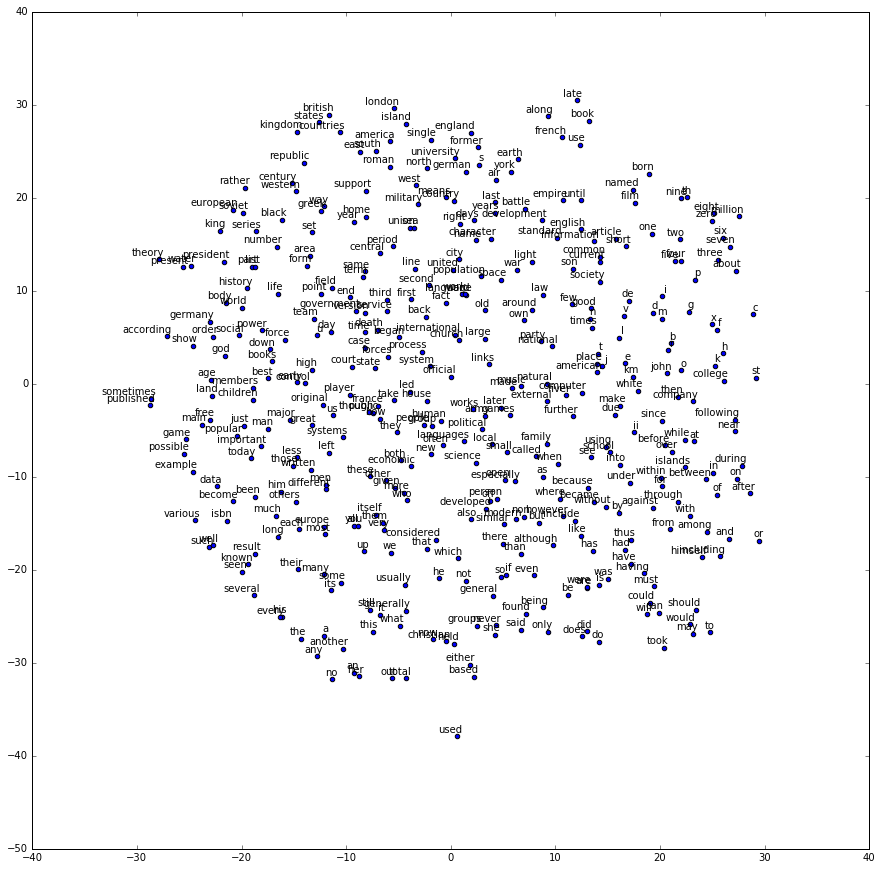

In [221]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)